In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('transaction_dataset.csv')
# select a balanced subset 100 rows with 50% true, 50% fake in dataset
print(df.info())
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [3]:
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")

Unnamed: 0: 7121 unique values
Index: 4191 unique values
Address: 7104 unique values
FLAG: 2 unique values
Avg min between sent tnx: 4054 unique values
Avg min between received tnx: 4058 unique values
Time Diff between first and last (Mins): 5629 unique values
Sent tnx: 493 unique values
Received Tnx: 468 unique values
Number of Created Contracts: 17 unique values
Unique Received From Addresses: 196 unique values
Unique Sent To Addresses: 222 unique values
min value received: 3829 unique values
max value received : 4540 unique values
avg val received: 4586 unique values
min val sent: 3851 unique values
max val sent: 5588 unique values
avg val sent: 4579 unique values
min value sent to contract: 3 unique values
max val sent to contract: 4 unique values
avg value sent to contract: 4 unique values
total transactions (including tnx to create contract: 645 unique values
total Ether sent: 4595 unique values
total ether received: 4555 unique values
total ether sent contracts: 4 unique values


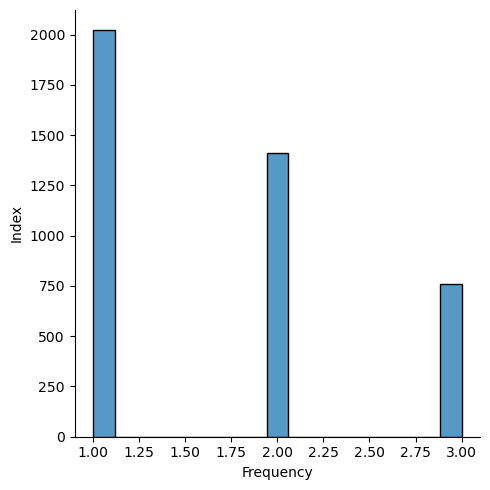

In [4]:
sns.displot(df['Index'].value_counts())
plt.ylabel('Index')
plt.xlabel('Frequency')
plt.show()

In [5]:
df = df.drop(columns=['Unnamed: 0','Index','Address'])

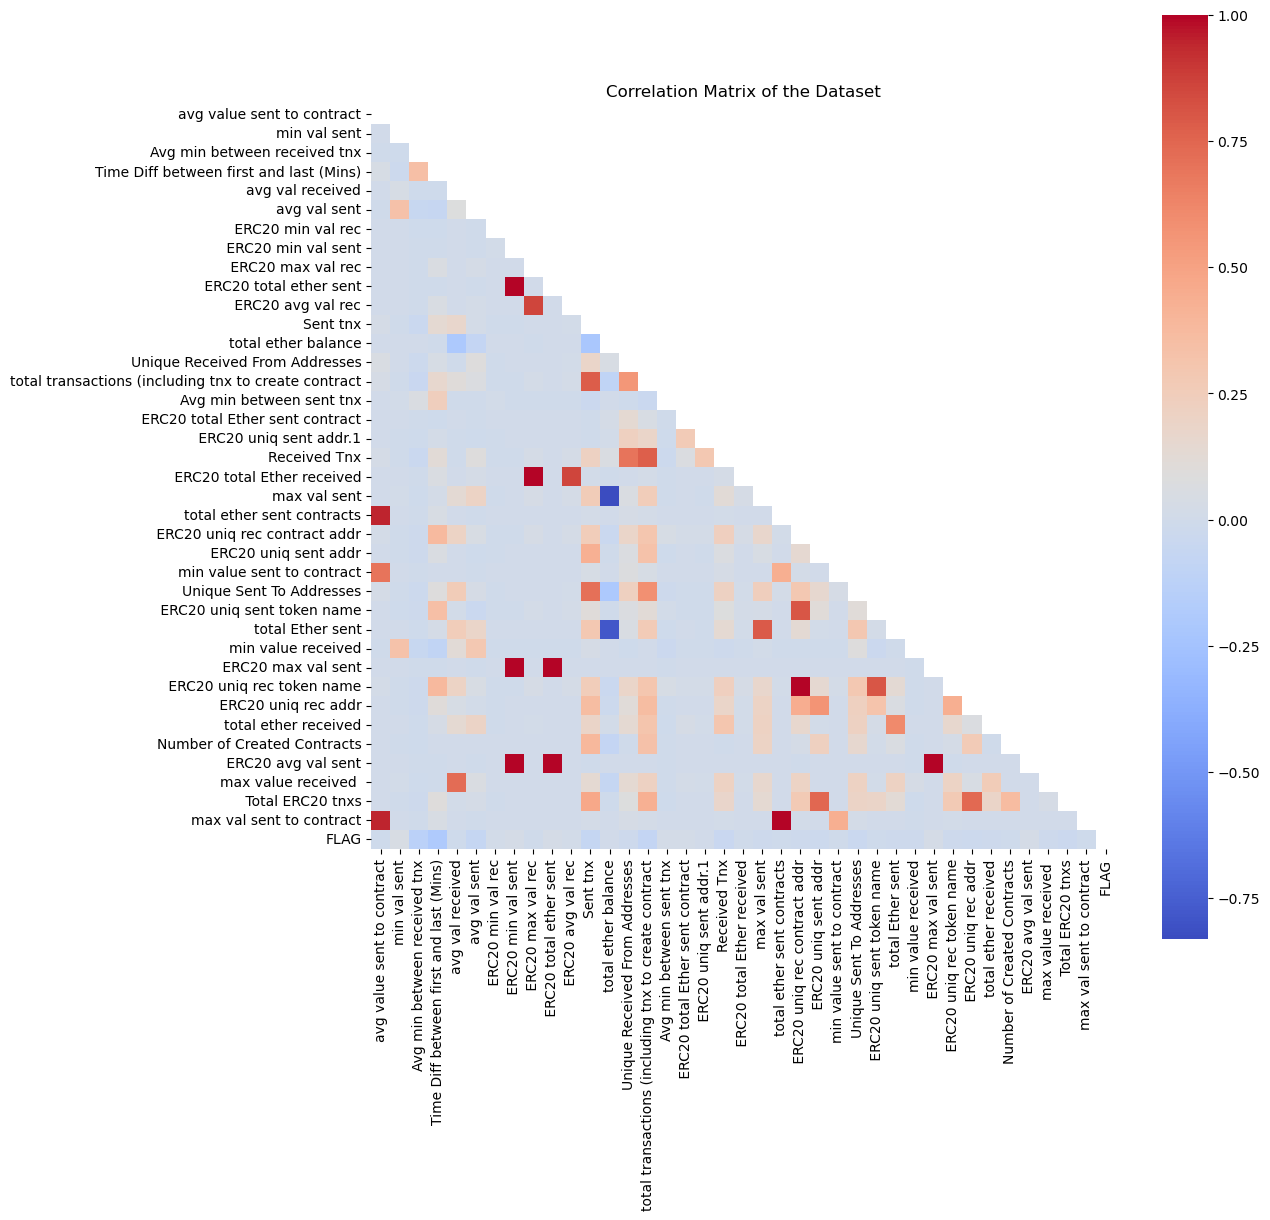

In [6]:
zero_feature_list = df.columns[(df.nunique() == 1)].tolist()
feature_list = list(set(df.columns) - set(['FLAG']) - set(zero_feature_list))
num_feature_list = list(set(feature_list) - set(df.dtypes[df.dtypes == 'object'].index) - set(zero_feature_list))

corr = df[num_feature_list + ['FLAG']].corr()
mask = np.zeros_like(corr);
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True, cmap='coolwarm')
plt.title('Correlation Matrix of the Dataset')
plt.show()

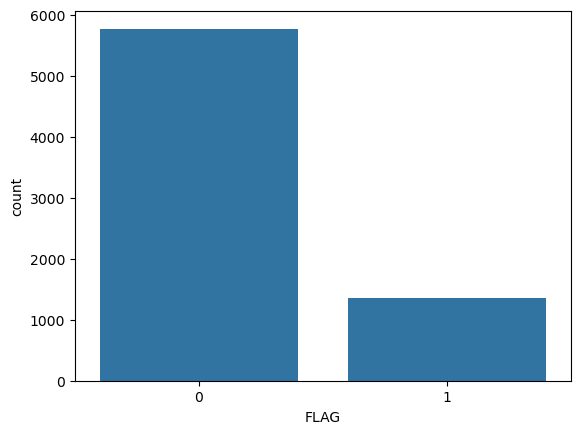

Distribution of FLAG:  0.18958011515236625


In [7]:
sns.countplot(data=df, x='FLAG')
plt.show()
print('Distribution of FLAG: ', df['FLAG'].mean())

In [8]:
X = df.drop(['FLAG'], axis=1)
y = df['FLAG']

In [9]:
le = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = le.fit_transform(X[column]) 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [11]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

/var/folders/m_/9b11rh5j3kjfpgjn4y9twzv40000gn/T/ipykernel_49885/2818983544.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis')
/var/folders/m_/9b11rh5j3kjfpgjn4y9twzv40000gn/T/ipykernel_49885/2818983544.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='viridis')


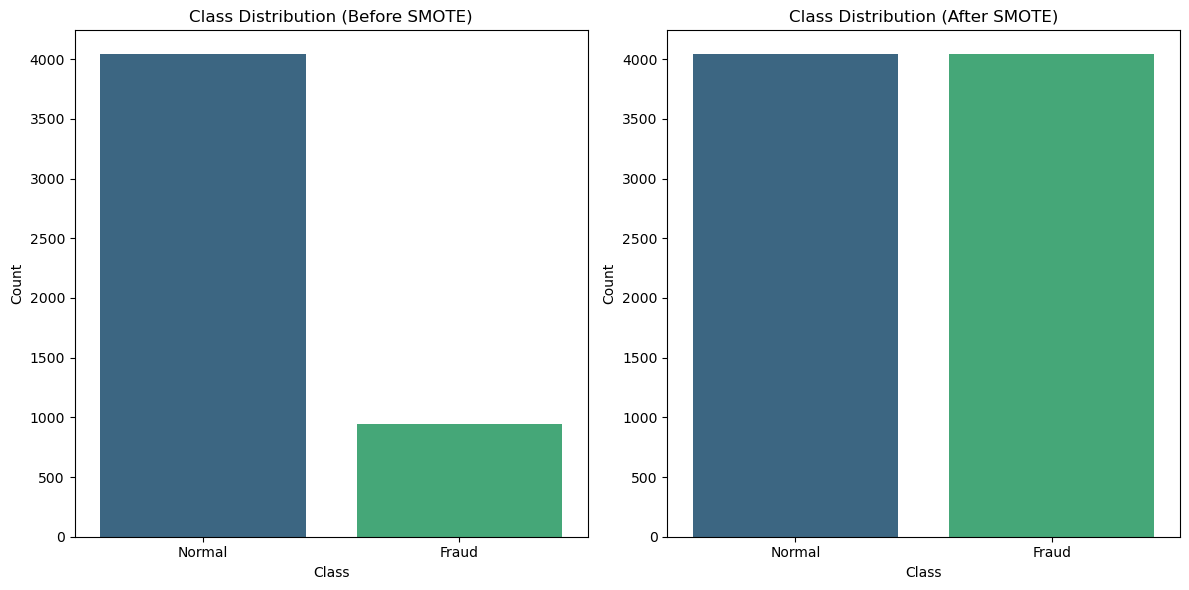

In [12]:
def plot_class_distribution(y_train, y_resampled):
    plt.figure(figsize=(12, 6))

    # Original class distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train, palette='viridis')
    plt.title('Class Distribution (Before SMOTE)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Normal', 'Fraud'])

    # Resampled class distribution
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled, palette='viridis')
    plt.title('Class Distribution (After SMOTE)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Normal', 'Fraud'])

    plt.tight_layout()
    plt.show()

# Call the function to visualize class distributions
plot_class_distribution(y_train, y_resampled)

In [13]:
clf = RandomForestClassifier(random_state=42)

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(clf, X_resampled, y_resampled, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cross_val_scores}")
print(f"Average cross-validation accuracy: {cross_val_scores.mean()}")

Cross-validation accuracy scores: [0.99319307 0.99443069 0.9950495  0.99504644 0.99566563]
Average cross-validation accuracy: 0.9946770683260275


In [15]:
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = clf.predict(X_test)

In [17]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1732
           1       1.00      0.95      0.97       405

    accuracy                           0.99      2137
   macro avg       0.99      0.97      0.98      2137
weighted avg       0.99      0.99      0.99      2137



In [18]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1732    0]
 [  22  383]]


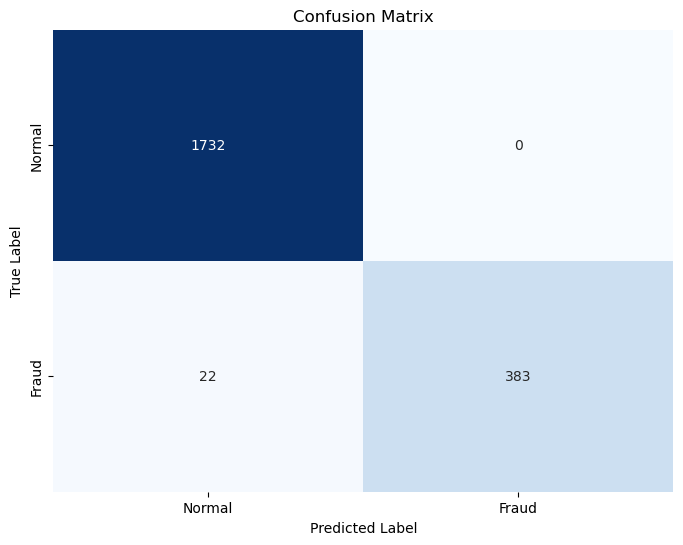

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f"Confusion Matrix Accuracy: {accuracy:.4f}")

Confusion Matrix Accuracy: 0.9897


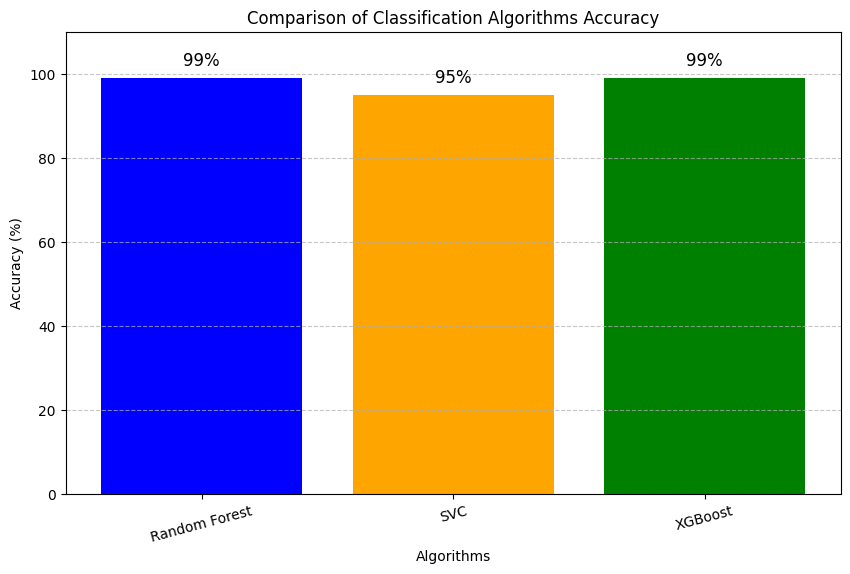

In [3]:
# Data for plotting
algorithms = ['Random Forest', 'SVC', 'XGBoost']
accuracies = [99, 95, 99]

# Creating the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 110)  # Set y-axis limit to give some space above the highest bar
plt.title('Comparison of Classification Algorithms Accuracy')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding percentages on top of the bars
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2,  # Positioning the text
             f'{yval}%', ha='center', va='bottom', fontsize=12)  # Adding the percentage text

plt.show()
